In [1]:
import numpy as np
import scipy.integrate as integrate
import random
import scipy.stats as stats

import math
import pandas as pd
import csv
import matplotlib.pyplot as plt

# Notation we use below.
arctan = np.arctan
cos = np.cos
det = np.linalg.det
exp = np.exp
inner = np.inner
log = np.log
matmul = np.matmul
norm = np.linalg.norm
odeint = integrate.odeint
pi = np.pi
quad = integrate.quad
randbinom = np.random.binomial
randexp = np.random.exponential
randnorm = np.random.normal
randperm = np.random.permutation
randuni = np.random.uniform
sin = np.sin
sqrt = np.sqrt

In [2]:
# access csv files, change file name as necessary
casesData = pd.read_csv('CDC052322.csv', skiprows=(0,1))
varData = pd.read_csv('CovidProps.csv')
casesData[169:190]

,State,Date,New Cases,7-Day Moving Avg,Historic Cases
169,United States,Nov 29 2021,94290,80543,171
170,United States,Nov 28 2021,56511,87844,92
171,United States,Nov 27 2021,51853,85238,51
172,United States,Nov 26 2021,81711,84367,19
173,United States,Nov 25 2021,71999,88932,76
174,United States,Nov 24 2021,106576,94809,245
175,United States,Nov 23 2021,100866,94593,126
176,United States,Nov 22 2021,145392,94237,50
177,United States,Nov 21 2021,38271,92549,490
178,United States,Nov 20 2021,45759,91887,81


In [3]:
# specify columns, convert to numpy
dates = pd.DataFrame(casesData, columns=['Date'])
avgCases = pd.DataFrame(casesData, columns=['7-Day Moving Avg'])
dates = pd.DataFrame.to_numpy(dates, dtype=str)
avgCases = pd.DataFrame.to_numpy(avgCases, dtype=int)

len(dates) # 846. START dates[15] = May Second.
dates2 = dates[15:]
avgCases = avgCases[15:]

# preallocate empty lists for biweekly dates and cases
biweeklyDates = []
biweeklyCases = []

n = 0
for i in range(36):
    biweeklyDates.append(dates2[n,0]) # why are we fetching the last 15 dates?
    # print(datestest[n,0])
    biweeklyCases.append(avgCases[n,0])
    n = n + 14 # printing every 14th date.

# fix the last date manually (Christmas week testing was skipped)
biweeklyDates[-1] = 'Dec 21 2021'
biweeklyCases[-1] = 162658

In [4]:
biweeklyDates# backwards in time.

['May  2 2022',
 'Apr 18 2022',
 'Apr  4 2022',
 'Mar 21 2022',
 'Mar  7 2022',
 'Feb 21 2022',
 'Feb  7 2022',
 'Jan 24 2022',
 'Jan 10 2022',
 'Dec 27 2021',
 'Dec 13 2021',
 'Nov 29 2021',
 'Nov 15 2021',
 'Nov  1 2021',
 'Oct 18 2021',
 'Oct  4 2021',
 'Sep 20 2021',
 'Sep  6 2021',
 'Aug 23 2021',
 'Aug  9 2021',
 'Jul 26 2021',
 'Jul 12 2021',
 'Jun 28 2021',
 'Jun 14 2021',
 'May 31 2021',
 'May 17 2021',
 'May  3 2021',
 'Apr 19 2021',
 'Apr  5 2021',
 'Mar 22 2021',
 'Mar  8 2021',
 'Feb 22 2021',
 'Feb  8 2021',
 'Jan 25 2021',
 'Jan 11 2021',
 'Dec 21 2021']

In [5]:
# forward in time.
biweeklyDates.reverse()
biweeklyDates # forward in time.

['Dec 21 2021',
 'Jan 11 2021',
 'Jan 25 2021',
 'Feb  8 2021',
 'Feb 22 2021',
 'Mar  8 2021',
 'Mar 22 2021',
 'Apr  5 2021',
 'Apr 19 2021',
 'May  3 2021',
 'May 17 2021',
 'May 31 2021',
 'Jun 14 2021',
 'Jun 28 2021',
 'Jul 12 2021',
 'Jul 26 2021',
 'Aug  9 2021',
 'Aug 23 2021',
 'Sep  6 2021',
 'Sep 20 2021',
 'Oct  4 2021',
 'Oct 18 2021',
 'Nov  1 2021',
 'Nov 15 2021',
 'Nov 29 2021',
 'Dec 13 2021',
 'Dec 27 2021',
 'Jan 10 2022',
 'Jan 24 2022',
 'Feb  7 2022',
 'Feb 21 2022',
 'Mar  7 2022',
 'Mar 21 2022',
 'Apr  4 2022',
 'Apr 18 2022',
 'May  2 2022']

In [6]:
# STARTING DATE: 12/21 - 5/02
percentDelta = pd.DataFrame(varData, columns=['perc_deltas'])
percentOmicron = pd.DataFrame(varData, columns=['perc_omicrons'])
percentBA45 = pd.DataFrame(varData, columns=['perc_ba45'])

percentDelta = pd.DataFrame.to_numpy(percentDelta, dtype=float)
percentOmicron = pd.DataFrame.to_numpy(percentOmicron, dtype=float)
percentBA45 = pd.DataFrame.to_numpy(percentBA45, dtype=float)


# append num_ variables to varData

numDelta = []
numOmicron = []
numBA45 = []
for i in range(len(biweeklyDates)):
    delta = percentDelta[i,0]*biweeklyCases[i]
    numDelta.append(delta)
    
    omicron = percentOmicron[i,0]*biweeklyCases[i]
    numOmicron.append(omicron)
    
    BA45 = percentBA45[i,0]*biweeklyCases[i]
    numBA45.append(BA45)
    


finalTable = [['Dates', 'Percent Delta', 'Percent Omicron', 'Percent Ba45', '# of Delta', '# of Omicron', '# of BA45', '# of Total Cases']]
for i in range(len(biweeklyDates)):
    finalTable.append([biweeklyDates[i], percentDelta[i][0], percentOmicron[i][0], percentBA45[i][0], numDelta[i], numOmicron[i], numBA45[i], biweeklyCases[i]])

In [7]:
varData["numDelta"] = numDelta
varData["numOmicron"] = numOmicron
varData["numBA45"] = numBA45
varData["biweeklyDates"] = biweeklyDates
varData["biweeklyCases"] = biweeklyCases
varData # note: before sept. 2021 all the percentages (delta, omicron, ba45) do not add to 1 because of the presence of beta.

# varData.to_csv('covid_variants_cases.csv')


,week,total_sequences,deltas,omicrons,ba45,perc_deltas,perc_omicrons,perc_ba45,numDelta,numOmicron,numBA45,biweeklyDates,biweeklyCases
0,2020-12-21,36771,11,0,0,0.000299,0.000000,0.000000,18.135297,0.000000,0.000000,Dec 21 2021,60623
1,2021-01-11,35804,4,0,0,0.000112,0.000000,0.000000,4.172048,0.000000,0.000000,Jan 11 2021,37344
2,2021-01-25,31768,1,0,0,0.000031,0.000000,0.000000,0.786357,0.000000,0.000000,Jan 25 2021,24981
3,2021-02-08,34820,1,0,0,0.000029,0.000000,0.000000,0.767088,0.000000,0.000000,Feb 8 2021,26710
4,2021-02-22,37323,2,0,0,0.000054,0.000000,0.000000,2.066715,0.000000,0.000000,Feb 22 2021,38568
5,2021-03-08,48910,5,0,0,0.000102,0.000000,0.000000,7.936312,0.000000,0.000000,Mar 8 2021,77633
6,2021-03-22,66582,23,0,0,0.000345,0.000000,0.000000,85.241837,0.000000,0.000000,Mar 22 2021,246764
7,2021-04-05,77663,97,0,0,0.001249,0.000000,0.000000,869.539060,0.000000,0.000000,Apr 5 2021,696196
8,2021-04-19,66041,467,0,0,0.007071,0.000000,0.000000,5381.775291,0.000000,0.000000,Apr 19 2021,761066
9,2021-05-03,49602,837,0,0,0.016874,0.000000,0.000000,4314.156042,0.000000,0.000000,May 3 2021,255664


In [8]:
### Old (Skip)

# access csv files, change file name as necessary
casesData = pd.read_csv('CDC052322.csv', skiprows=(0,1))
varData = pd.read_csv('CovidProps.csv')

# specify columns, convert to numpy
dates = pd.DataFrame(casesData, columns=['Date'])
avgCases = pd.DataFrame(casesData, columns=['7-Day Moving Avg'])
dates = pd.DataFrame.to_numpy(dates, dtype=str)
avgCases = pd.DataFrame.to_numpy(avgCases, dtype=int)

percentDelta = pd.DataFrame(varData, columns=['perc_deltas'])
percentOmicron = pd.DataFrame(varData, columns=['perc_omicrons'])
percentBA45 = pd.DataFrame(varData, columns=['perc_BA45'])

percentDelta = pd.DataFrame.to_numpy(percentDelta, dtype=float)
percentOmicron = pd.DataFrame.to_numpy(percentOmicron, dtype=float)
percentBA45 = pd.DataFrame.to_numpy(percentBA45, dtype=float)

# preallocate empty lists for biweekly dates and cases
biweeklyDates = []
biweeklyCases = []
n = None

#fill in biweekly dates/cases based on starting date (Dec 21 2021)
for i in range(len(dates[:,0])):
    j = len(dates[:,0]) - 1 - i
    if dates[j,0] == 'Dec 21 2021':
        biweeklyDates.append(dates[j,0])
        biweeklyCases.append(avgCases[j,0])
        n = j
        break

for i in range(35):
    n = n - 14
    biweeklyDates.append(dates[n,0])
    biweeklyCases.append(avgCases[n,0])


numDelta = []
numOmicron = []
numBA45 = []
for i in range(len(biweeklyDates)):
    delta = percentDelta[i,0]*biweeklyCases[i]
    numDelta.append(delta)
    omicron = percentOmicron[i,0]*biweeklyCases[i]
    numOmicron.append(omicron)
    BA45 = percentBA45[i,0]*biweeklyCases[i]
    numBA45.append(BA45)
    


finalTable = [['Dates', 'Percent Delta', 'Percent Omicron', 'Percent Ba45', '# of Delta', '# of Omicron', '# of BA45', '# of Total Cases']]
for i in range(len(biweeklyDates)):
    finalTable.append([biweeklyDates[i], percentDelta[i][0], percentOmicron[i][0], percentBA45[i][0], numDelta[i], numOmicron[i], numBA45[i], biweeklyCases[i]])
    

In [9]:
biweeklyDates


['Dec 21 2021',
 'Jan  4 2022',
 'Jan 18 2022',
 'Feb  1 2022',
 'Feb 15 2022',
 'Mar  1 2022',
 'Mar 15 2022',
 'Mar 29 2022',
 'Apr 12 2022',
 'Apr 26 2022',
 'May 10 2022',
 'Jan 29 2020',
 'Feb 12 2020',
 'Feb 26 2020',
 'Mar 11 2020',
 'Mar 25 2020',
 'Apr  8 2020',
 'Apr 22 2020',
 'May  6 2020',
 'May 20 2020',
 'Jun  3 2020',
 'Jun 17 2020',
 'Jul  1 2020',
 'Jul 15 2020',
 'Jul 29 2020',
 'Aug 12 2020',
 'Aug 26 2020',
 'Sep  9 2020',
 'Sep 23 2020',
 'Oct  7 2020',
 'Oct 21 2020',
 'Nov  4 2020',
 'Nov 18 2020',
 'Dec  2 2020',
 'Dec 16 2020',
 'Dec 30 2020']

In [10]:
len(numDelta) # len(numDelta) = 35



36

In [11]:
N = 329000000
propDelta = [numDelta[i]/N for i in range(len(numDelta))]
propDelta
propOmicron = [numOmicron[i]/N for i in range(len(numOmicron))]
propAll = [biweeklyCases[i]/N for i in range(len(biweeklyCases))]

In [12]:
# finalTable # 36 time points

## Start here if you have covid_variants_cases.csv

In [26]:
covid_vc = pd.read_csv('covid_variants_cases.csv')
covid_vc[:]


,Unnamed: 0,week,total_sequences,deltas,omicrons,ba45,perc_deltas,perc_omicrons,perc_ba45,numDelta,numOmicron,numBA45,biweeklyDates,biweeklyCases
0,0,2020-12-21,36771,11,0,0,0.000299,0.000000,0.000000,18.135297,0.000000,0.000000,Dec 21 2021,60623
1,1,2021-01-11,35804,4,0,0,0.000112,0.000000,0.000000,4.172048,0.000000,0.000000,Jan 11 2021,37344
2,2,2021-01-25,31768,1,0,0,0.000031,0.000000,0.000000,0.786357,0.000000,0.000000,Jan 25 2021,24981
3,3,2021-02-08,34820,1,0,0,0.000029,0.000000,0.000000,0.767088,0.000000,0.000000,Feb 8 2021,26710
4,4,2021-02-22,37323,2,0,0,0.000054,0.000000,0.000000,2.066715,0.000000,0.000000,Feb 22 2021,38568
5,5,2021-03-08,48910,5,0,0,0.000102,0.000000,0.000000,7.936312,0.000000,0.000000,Mar 8 2021,77633
6,6,2021-03-22,66582,23,0,0,0.000345,0.000000,0.000000,85.241837,0.000000,0.000000,Mar 22 2021,246764
7,7,2021-04-05,77663,97,0,0,0.001249,0.000000,0.000000,869.539060,0.000000,0.000000,Apr 5 2021,696196
8,8,2021-04-19,66041,467,0,0,0.007071,0.000000,0.000000,5381.775291,0.000000,0.000000,Apr 19 2021,761066
9,9,2021-05-03,49602,837,0,0,0.016874,0.000000,0.000000,4314.156042,0.000000,0.000000,May 3 2021,255664


In [91]:
a = covid_vc["week"][1]

In [99]:
from datetime import datetime

ds = []

for d in range(len(covid_vc["week"])):
    print(datetime.strptime(covid_vc["week"][d], "%Y-%m-%d"))
    ds.append(datetime.strptime(covid_vc["week"][d], "%Y-%m-%d"))
ds
covid_vc["date_time"] = ds

2020-12-21 00:00:00
2021-01-11 00:00:00
2021-01-25 00:00:00
2021-02-08 00:00:00
2021-02-22 00:00:00
2021-03-08 00:00:00
2021-03-22 00:00:00
2021-04-05 00:00:00
2021-04-19 00:00:00
2021-05-03 00:00:00
2021-05-17 00:00:00
2021-05-31 00:00:00
2021-06-14 00:00:00
2021-06-28 00:00:00
2021-07-12 00:00:00
2021-07-26 00:00:00
2021-08-09 00:00:00
2021-08-23 00:00:00
2021-09-06 00:00:00
2021-09-20 00:00:00
2021-10-04 00:00:00
2021-10-18 00:00:00
2021-11-01 00:00:00
2021-11-15 00:00:00
2021-11-29 00:00:00
2021-12-13 00:00:00
2021-12-27 00:00:00
2022-01-10 00:00:00
2022-01-24 00:00:00
2022-02-07 00:00:00
2022-02-21 00:00:00
2022-03-07 00:00:00
2022-03-21 00:00:00
2022-04-04 00:00:00
2022-04-18 00:00:00
2022-05-02 00:00:00


Text(0, 0.5, 'Prop of Population Infected')

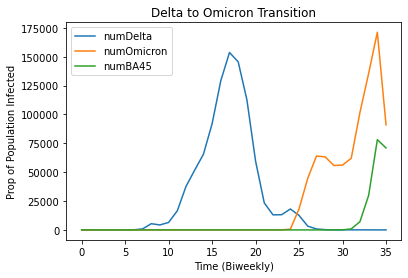

In [28]:
fig, ax = plt.subplots()
ax.plot(covid_vc["numDelta"], label='numDelta')
ax.plot(covid_vc["numOmicron"], label='numOmicron')
ax.plot(covid_vc["numBA45"], label='numBA45')
legend = ax.legend(loc='upper left')
plt.title('Delta to Omicron Transition')
plt.xlabel('Time (Biweekly)')
plt.ylabel('Prop of Population Infected')       

In [29]:
# SIR Ordinary Differential Equation
def V(x,t,beta,gamma):
    return [-beta*x[0]*x[1], beta*x[0]*x[1]-gamma*x[1], gamma*x[1]] # [s(t), i(t), r(t)]

In [30]:
# Fitting a range of different beta values. Play around with this!
beta_grid = np.linspace(start=.1, stop=2, num=20)
print(beta_grid)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]


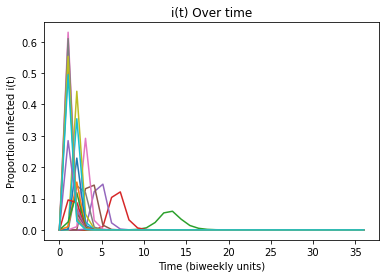

In [31]:
# Population size
N = 329000000

# fix gamma (5 day recovery)
gamma = 0.2

for beta in beta_grid: 
    
    # Initial condition; i_0 is the initial number of infected people
    i_0 = 1/N
    x = [1-i_0, i_0, 0]

    # Time
    days = 36*14
    steps = 36
    T = np.linspace(0,days,steps)

    # Integrate (aka solve) the ODE; phi is the solution phi=[s(t), i(t), r(t)]
    phi = odeint(V, x, T, args=(beta,gamma)) 

    # s compartment
    s = phi[:,0]
    # i compartment
    i = phi[:,1]
    # r compartment
    r = phi[:,2]
    
    
    # Plots of the solved differential equations
    plt.plot(T/14,i,label="i")
    plt.xlabel('Time (biweekly units)')
    plt.ylabel('Proportion Infected i(t)')
    plt.title('i(t) Over time')

Although the shape of the Omicron curve is very similar to an approximat [beta, gamma] = [0.4, 0.2] (with r0 = 2) the proportion truly infected in the data is quite low.

### Logistic Growth Model
#### DOES THE PROPORTION OF A MORE VIRULENT STRAIN FIT A LOGISTIC GROWTH CURVE?

In [32]:
def L(x,t,beta,gamma):
    '''
    logistic growth curve differential equation.
    '''
    return [-beta*x[0]*x[1], x[1]*(1-x[1])*beta*1] # [ignore, i_2_prop]

In [33]:
# Figuring out Time Units on X axis
days = 14*36 # two weeks * 36 
steps = 14 # plot a point every 2 weeks
T = np.linspace(0,days,steps)
print(T) # in days
print(T/14) # in biweekly timeunits.

[  0.          38.76923077  77.53846154 116.30769231 155.07692308
 193.84615385 232.61538462 271.38461538 310.15384615 348.92307692
 387.69230769 426.46153846 465.23076923 504.        ]
[ 0.          2.76923077  5.53846154  8.30769231 11.07692308 13.84615385
 16.61538462 19.38461538 22.15384615 24.92307692 27.69230769 30.46153846
 33.23076923 36.        ]


In [34]:
# Play around with this grid of values.
diff_beta_grid = np.linspace(start=.1, stop=.2, num=10)
diff_beta_grid

array([0.1       , 0.11111111, 0.12222222, 0.13333333, 0.14444444,
       0.15555556, 0.16666667, 0.17777778, 0.18888889, 0.2       ])

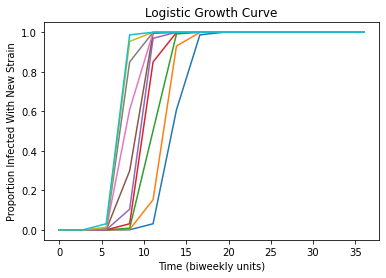

In [35]:
# Population size of USA
N = 329000000

for diff_beta in diff_beta_grid: 
    
    # proportions of i_1 and i_2
    prop_i_2 = 1/N # initial proportion of variant 2: i_2/(i_2+i_1) (find what epsilon*N)
    x = [1-prop_i_2, prop_i_2] # (i_1/(i_2+i_1), i_2/(i_2+i_1))

    
    # Time units
    days = 14*36 # two weeks * 36 
    steps = 14 # every 2 weeks
    T = np.linspace(0,days,steps)

    # Integrate (aka solve) the ODE; the logistic_vector is the solution.
    logistic_vector = odeint(L, x, T, args=(diff_beta, gamma)) 

    i_logistic_curve = logistic_vector[:,1]

    # plot
    plt.plot(T/14,i_logistic_curve,label="Logistic Growth")
    plt.xlabel('Time (biweekly units)')
    plt.ylabel('Proportion Infected With New Strain')
    plt.title('Logistic Growth Curve')

Text(0.5, 0.98, 'Proportion of Cases Omicron B1/2')

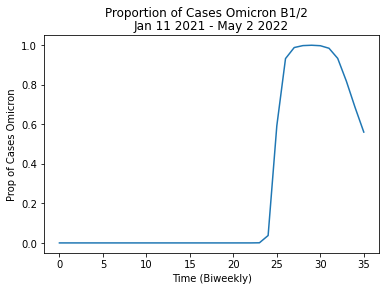

In [36]:
# Data From True Omicron Props.
fig, ax = plt.subplots()
ax.plot(percentOmicron, label='Prop of Cases Omicron')

plt.xlabel('Time (Biweekly)')
plt.ylabel('Prop of Cases Omicron')  
plt.title('Jan 11 2021 - May 2 2022')
plt.suptitle("Proportion of Cases Omicron B1/2")

## Code to solve logistic equations

In [49]:
def solve_logistic(y0, y1, delta_t):
    '''
    param:
    y0 - initial proportion infectious
    y1 - final proportion infectious
    delta_t - change in time (days)
    return: lambda = beta_2 - beta_1
    '''
    b = 1/y0 - 1
    diff_b = -1/delta_t * log((1/b)*(1/y1 - 1))
    
    return diff_b



In [50]:
# Beta to delta
# These two data points give the start to end of the logistic growth curve.

# (date1, percentdelta) = (May 3, 2021, 0.016874)
# (date2, percentdelta) = (Jul 26 2021, 0.899738)

print(solve_logistic(0.016874, 0.899738, 84)) # 0.0745
diff_betadelta = solve_logistic(0.016874, 0.899738, 84)

# Delta to omicron BA1/2/3
# These two data points give the start to end of the logistic growth curve.

# (date1, percentOmicron) = (Nov 29 2021, 0.037709327)
# (date2, percentOmicron) = (Jan 10 2022, 0.986774)

print(solve_logistic(0.037709327, 0.986774, 42)) # 0.1798
diff_omicronba123 = solve_logistic(0.037709327, 0.986774, 42)

# Omicron BA1/2/3 to BA4/5
# These two data points give the start to end of the logistic growth curve.

# (date1, percentBA4/5) = (Mar 21 2022, 0.065300)
# (date2, percentBA4/5) = (May 2 2022, 0.436607)

print(solve_logistic(0.014231, 0.065300, 42)) # 0.0711
diff_ba123_ba45 = solve_logistic(0.014231, 0.065300, 42)




0.0745152400630254
0.1798015605426319
0.037542042324482584


Text(0, 0.5, 'Prop of Cases Delta')

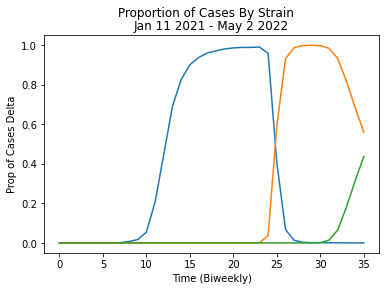

In [59]:
# Data From True Delta Props.
fig, ax = plt.subplots()
ax.plot(covid_vc["perc_deltas"], label='Prop of Cases Omicron')
ax.plot(covid_vc["perc_omicrons"], label='Prop of Cases Omicron')
ax.plot(covid_vc["perc_ba45"], label='Prop of Cases Omicron')

plt.title('Jan 11 2021 - May 2 2022')
plt.suptitle("Proportion of Cases By Strain")
plt.xlabel('Time (Biweekly)')
plt.ylabel('Prop of Cases Delta')


Text(0.5, 0.98, 'Proportion of Cases By Strain (Jan 11 2021 - May 2 2022)')

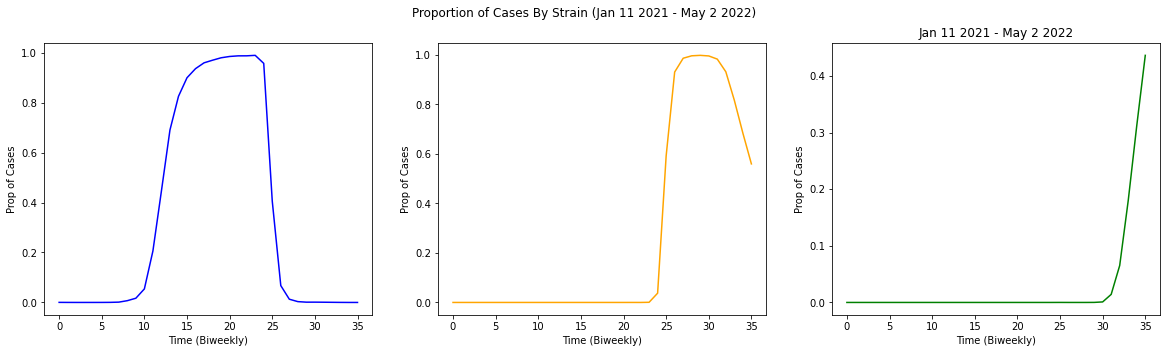

In [60]:
# Data from the 3 waves.

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(20, 5)
fig.suptitle('Variant Competition')
plt.title('Jan 11 2021 - May 2 2022')

ax1.plot(covid_vc["perc_deltas"], label='Prop of Cases Omicron', color = 'blue')
ax1.set_xlabel('Time (Biweekly)')
ax1.set_ylabel('Prop of Cases') 

ax2.plot(covid_vc["perc_omicrons"], label='Prop of Cases Omicron', color = 'orange')
ax2.set_xlabel('Time (Biweekly)')
ax2.set_ylabel('Prop of Cases') 

ax3.plot(covid_vc["perc_ba45"], label='Prop of Cases Omicron', color = 'green')
ax3.set_xlabel('Time (Biweekly)')
ax3.set_ylabel('Prop of Cases') 

fig.suptitle("Proportion of Cases By Strain (Jan 11 2021 - May 2 2022)")
# fig.subtitle('Jan 11 2021 - May 2 2022')



In [65]:
diff_betadelta

0.0745152400630254

In [104]:
# proportions of i_1 and i_2
prop_i_2 = 1/N # initial proportion of variant 2: i_2/(i_2+i_1) (find what epsilon*N)
x = [1-prop_i_2, prop_i_2] # (i_1/(i_2+i_1), i_2/(i_2+i_1))

# Time units
days = 14*36 # two weeks * 36 
steps = 14 # every 2 weeks
T = np.linspace(0,days,steps)

# Integrate (aka solve) the ODE; the logistic_vector is the solution.
logistic_vector1 = odeint(L, x, T, args=(diff_betadelta, gamma)) 
logistic_vector2 = odeint(L, x, T, args=(diff_omicronba123, gamma))
logistic_vector3 = odeint(L, x, T, args=(diff_ba123_ba45, gamma))

betadelta = logistic_vector1[:,1]
delta_omicron12 = logistic_vector2[:,1]
ba123_ba45 = logistic_vector3[:,1]


In [105]:
print(T)
print(betadelta)

[  0.          38.76923077  77.53846154 116.30769231 155.07692308
 193.84615385 232.61538462 271.38461538 310.15384615 348.92307692
 387.69230769 426.46153846 465.23076923 504.        ]
[3.03951368e-09 1.00340609e-07 1.88287360e-06 3.42485929e-05
 6.15745769e-04 1.09529325e-02 1.66001194e-01 7.81539785e-01
 9.84686083e-01 9.99135472e-01 9.99951859e-01 9.99997322e-01
 9.99999850e-01 9.99999992e-01]


In [106]:
# For creating aligned graphs: Align the start times of waves with logistic growth approximation.

# wave 1
# starting_frame = [0]*5
betadelta = starting_frame + list(betadelta)
# wave 2
# starting_frame = [0] * 22
delta_omicron12 = starting_frame + list(delta_omicron12)
# wave 3
# starting_frame = [0] * 21
ba123_ba45 = starting_frame + list(ba123_ba45)


Text(0.5, 0.98, 'Proportion of Cases By Strain (Jan 11 2021 - May 2 2022)')

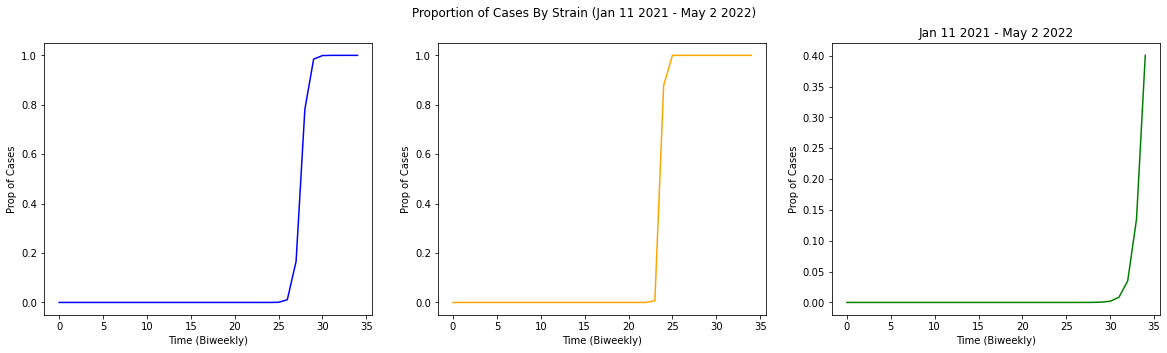

In [107]:
# Corresponding logistic growth curves with estimated b2-b1.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(20, 5)
fig.suptitle('Variant Competition')
plt.title('Jan 11 2021 - May 2 2022')

ax1.plot(betadelta, label='Prop of Cases Omicron', color = 'blue')
ax1.set_xlabel('Time (Biweekly)')
ax1.set_ylabel('Prop of Cases') 

ax2.plot(delta_omicron12, label='Prop of Cases Omicron', color = 'orange')
ax2.set_xlabel('Time (Biweekly)')
ax2.set_ylabel('Prop of Cases') 

ax3.plot(ba123_ba45, label='Prop of Cases Omicron', color = 'green')
ax3.set_xlabel('Time (Biweekly)')
ax3.set_ylabel('Prop of Cases') 

fig.suptitle("Proportion of Cases By Strain (Jan 11 2021 - May 2 2022)")
# fig.subtitle('Jan 11 2021 - May 2 2022')


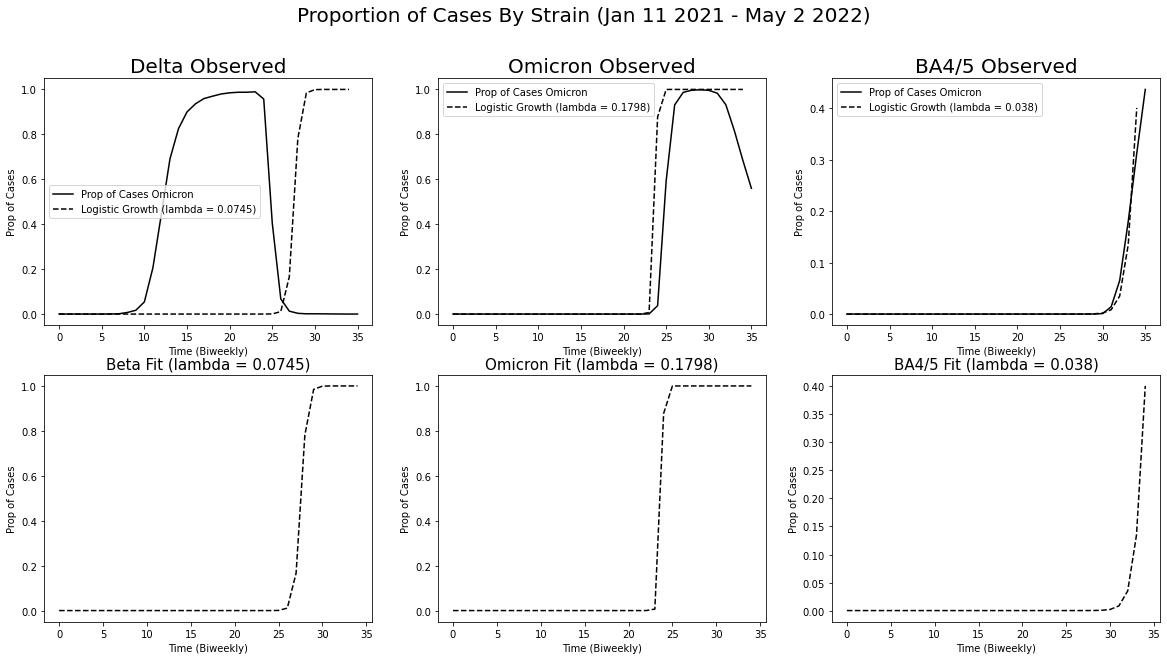

In [108]:
# Corresponding logistic growth curves with estimated b2-b1.
fig, ax = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(20, 10)

ax[0,0].plot(covid_vc["perc_deltas"], color='black', label='Prop of Cases Omicron')
ax[0,0].plot(betadelta, color='black', linestyle = '--', label='Logistic Growth (lambda = 0.0745)')
ax[0,0].set_xlabel('Time (Biweekly)')
ax[0,0].set_ylabel('Prop of Cases') 
ax[0,0].set_title("Delta Observed", fontsize='20')
ax[0,0].legend()

ax[0,1].plot(covid_vc["perc_omicrons"], color='black', label='Prop of Cases Omicron')
ax[0,1].plot(delta_omicron12, color='black', linestyle = '--', label='Logistic Growth (lambda = 0.1798)')
ax[0,1].set_xlabel('Time (Biweekly)')
ax[0,1].set_ylabel('Prop of Cases') 
ax[0,1].set_title("Omicron Observed", fontsize='20')
ax[0,1].legend()

ax[0,2].plot(covid_vc["perc_ba45"], color='black', label='Prop of Cases Omicron')
ax[0,2].plot(ba123_ba45, color='black', linestyle = '--', label='Logistic Growth (lambda = 0.038)')
ax[0,2].set_xlabel('Time (Biweekly)')
ax[0,2].set_ylabel('Prop of Cases')
ax[0,2].set_title("BA4/5 Observed", fontsize='20')
ax[0,2].legend()

ax[1,0].plot(betadelta, label='Prop of Cases Omicron', color='black', linestyle = '--')
ax[1,0].set_xlabel('Time (Biweekly)')
ax[1,0].set_ylabel('Prop of Cases')
ax[1,0].set_title("Beta Fit (lambda = 0.0745)", fontsize='15')

ax[1,1].plot(delta_omicron12, label='Prop of Cases Omicron',color='black',linestyle = '--')
ax[1,1].set_xlabel('Time (Biweekly)')
ax[1,1].set_ylabel('Prop of Cases')
ax[1,1].set_title("Omicron Fit (lambda = 0.1798)", fontsize='15')

ax[1,2].plot(ba123_ba45, label='Prop of Cases Omicron', color='black',linestyle = '--')
ax[1,2].set_xlabel('Time (Biweekly)')
ax[1,2].set_ylabel('Prop of Cases') 
ax[1,2].set_title("BA4/5 Fit (lambda = 0.038)", fontsize='15')

fig.suptitle("Proportion of Cases By Strain (Jan 11 2021 - May 2 2022)", fontsize='20')


fig.savefig('variant_competition_logistic.pdf')



In [84]:
covid_vc["logistic_perc_deltas"] = log( covid_vc["perc_deltas"]/(1-covid_vc["perc_deltas"]) )
covid_vc["logistic_perc_omicron"] = log(covid_vc["perc_omicrons"]/(1-covid_vc["perc_omicrons"]))
covid_vc["logistic_perc_ba45"] = log(covid_vc["perc_ba45"]/(1-covid_vc["perc_ba45"]))
covid_vc


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Unnamed: 0,week,total_sequences,deltas,omicrons,ba45,perc_deltas,perc_omicrons,perc_ba45,numDelta,numOmicron,numBA45,biweeklyDates,biweeklyCases,logistic_perc_deltas,logistic_perc_omicron,logistic_perc_ba45
0,0,2020-12-21,36771,11,0,0,0.000299,0.000000,0.000000,18.135297,0.000000,0.000000,Dec 21 2021,60623,-8.114270,-inf,-inf
1,1,2021-01-11,35804,4,0,0,0.000112,0.000000,0.000000,4.172048,0.000000,0.000000,Jan 11 2021,37344,-9.099409,-inf,-inf
2,2,2021-01-25,31768,1,0,0,0.000031,0.000000,0.000000,0.786357,0.000000,0.000000,Jan 25 2021,24981,-10.366183,-inf,-inf
3,3,2021-02-08,34820,1,0,0,0.000029,0.000000,0.000000,0.767088,0.000000,0.000000,Feb 8 2021,26710,-10.457918,-inf,-inf
4,4,2021-02-22,37323,2,0,0,0.000054,0.000000,0.000000,2.066715,0.000000,0.000000,Feb 22 2021,38568,-9.834164,-inf,-inf
5,5,2021-03-08,48910,5,0,0,0.000102,0.000000,0.000000,7.936312,0.000000,0.000000,Mar 8 2021,77633,-9.188197,-inf,-inf
6,6,2021-03-22,66582,23,0,0,0.000345,0.000000,0.000000,85.241837,0.000000,0.000000,Mar 22 2021,246764,-7.970350,-inf,-inf
7,7,2021-04-05,77663,97,0,0,0.001249,0.000000,0.000000,869.539060,0.000000,0.000000,Apr 5 2021,696196,-6.684173,-inf,-inf
8,8,2021-04-19,66041,467,0,0,0.007071,0.000000,0.000000,5381.775291,0.000000,0.000000,Apr 19 2021,761066,-4.944605,-inf,-inf
9,9,2021-05-03,49602,837,0,0,0.016874,0.000000,0.000000,4314.156042,0.000000,0.000000,May 3 2021,255664,-4.064944,-inf,-inf


Text(0, 0.5, 'Prop of Population Infected')

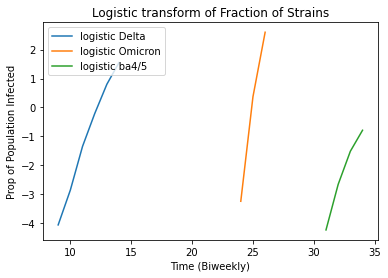

In [86]:
# According to page 4 of var_comp: Can we assume s(t) and r(t) are constant? 
fig, ax = plt.subplots()
ax.plot(covid_vc["logistic_perc_deltas"][9:15], label='logistic Delta')
ax.plot(covid_vc["logistic_perc_omicron"][24:27], label='logistic Omicron')
ax.plot(covid_vc["logistic_perc_ba45"][31:35], label='logistic ba4/5')
legend = ax.legend(loc='upper left')
plt.title('Logistic transform of Fraction of Strains')
plt.xlabel('Time (Biweekly)')
plt.ylabel('Prop of Population Infected')



In [ ]:
# How well does each logistic fit a line?

